# New particle formation event classification

This notebook supports the detection and description of new particle formation events that may have occurred on specific days and places. Start by setting up the notebook. You need to provide your GCUBE TOKEN and load the provided functions. After that you can start analysing data by providing the desired day (YYYY-MM-DD) and place (Hyytiaelae).

In [3]:
day = '2013-04-04'
place = 'Hyytiaelae'

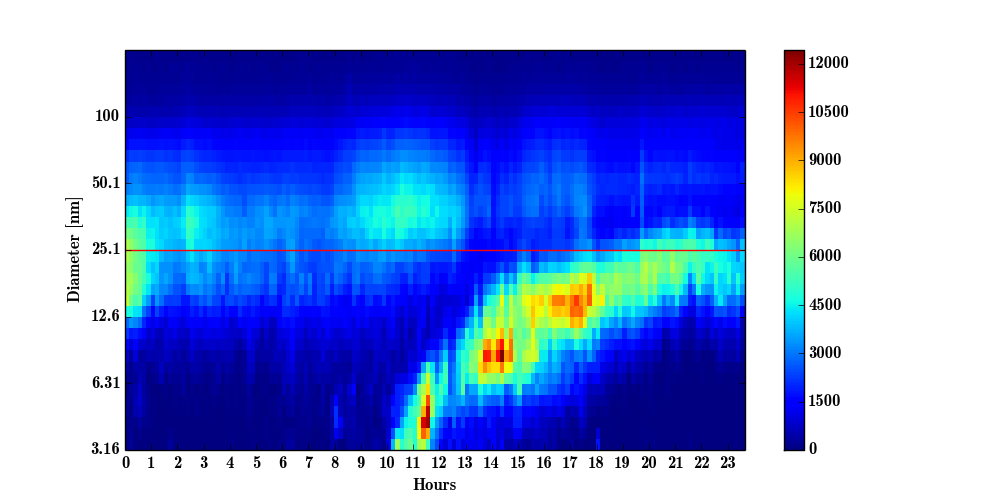

In [4]:
visualize(day, place)

In [5]:
record(day, place, '10:30', '12:00', 'Class Ia')

## Setup

In [1]:
# gcube_token = os.environ['GCUBE_TOKEN']
gcube_token = ''

In [2]:
import os
import logging
from IPython.display import Image, display
from io import BytesIO
from lxml import etree as et
from owslib.wps import WebProcessingService, ComplexDataInput, monitorExecution

logging.basicConfig()
logging.getLogger().setLevel(logging.ERROR)

dataminer_url = 'http://dataminer-prototypes.d4science.org/wps/WebProcessingService'

headers = {'gcube-token': gcube_token}
wps = WebProcessingService(dataminer_url, headers=headers)

def visualize(day, place):
    identifier = 'org.gcube.dataanalysis.wps.statisticalmanager.synchserver.mappedclasses.transducerers.PFFETCHPLOTDATA'
   
    inputs = [
        ('day', day),
        ('place', place)
    ]

    execution = wps.execute(identifier, inputs, output="non_deterministic_output")

    monitorExecution(execution, sleepSecs=5, download=False)

    for output in execution.processOutputs:
        doc = et.parse(BytesIO(output.retrieveData(headers=headers)))
        plotUrl = doc.xpath('/ogr:FeatureCollection/gml:featureMember/ogr:Result/d4science:Description[text() = "plot"]/../d4science:Data/text()', namespaces={
            'ogr': 'http://ogr.maptools.org/',
            'gml': 'http://www.opengis.net/gml',
            'd4science': 'http://www.d4science.org'
        })[0]
        display(Image(url=plotUrl, format='png', embed=True))
        
def record(day, place, beginning, end, classification):
    identifier = 'org.gcube.dataanalysis.wps.statisticalmanager.synchserver.mappedclasses.transducerers.PFSTOREDATA'
   
    inputs = [
        ('day', day),
        ('place', place),
        ('beginning', beginning),
        ('end', end),
        ('classification', classification)
    ]
    
    execution = wps.execute(identifier, inputs, output="non_deterministic_output")